In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torch.nn.functional as F
import pandas as pd
import pickle
import numpy as np
import classifier_util as util
from classifier import MultiConvClassifier
from classifier_util import BATCH_SIZE, NCLASSES, N_EPOCHS

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Initialization

In [4]:
# Read DataLoaders from pickle files
pkl_file = open('Data/dataLoaderVal.pkl', 'rb')
dl_val = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('Data/dataLoaderTrain.pkl', 'rb')
dl_train = pickle.load(pkl_file)
pkl_file.close()

c:\users\basic\matf\machine learning\project\venv1\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


## Training

In [7]:
# Training and plotting that uses validation data
def train_classification_with_validation(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    device = util.get_device()

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in train_loader:
                   
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5) * 1
            
            tensor_sum = predicted + labels
            intersection = torch.sum(tensor_sum > 1, 1)
            union = torch.sum(tensor_sum > 0, 1)
            ra = torch.sum(intersection / union)
            running_accuracy += ra

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = running_accuracy / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_running_accuracy = 0.0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs.squeeze(), val_labels)
                    val_running_loss += val_loss.item()
                
                    val_predicted = (torch.sigmoid(val_outputs) > 0.5) * 1
                    tensor_sum = val_predicted + val_labels
                    intersection = torch.sum(tensor_sum > 1 , 1)
                    union = torch.sum(tensor_sum > 0, 1)
                    
                    val_running_accuracy += torch.sum(intersection / union)

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_running_accuracy / len(validation_loader.dataset)
            
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

### M1 single classifier base with hyperparameter tuning

In [86]:
# 2 original dropout layers 
# weight decay also original

m1= MultiConvClassifier(NCLASSES)
m1 = util.bind_gpu(m1)
util.load_weights_from_dict(m1, 'Models/m1.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m1.parameters(), weight_decay = 0.01)

train_losses_m1, train_accuracies_m1, val_losses_m1, val_accuracies_m1 = train_classification_with_validation(m1, criterion, optimizer, N_EPOCHS, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/30], Train Loss: 0.3625, Train Accuracy: 0.0258
Epoch [1/30], Validation Loss: 0.2633, Validation Accuracy: 0.0524
Epoch [2/30], Train Loss: 0.2280, Train Accuracy: 0.1573
Epoch [2/30], Validation Loss: 0.2189, Validation Accuracy: 0.2359
Epoch [3/30], Train Loss: 0.2048, Train Accuracy: 0.2375
Epoch [3/30], Validation Loss: 0.2073, Validation Accuracy: 0.2497
Epoch [4/30], Train Loss: 0.1961, Train Accuracy: 0.2493
Epoch [4/30], Validation Loss: 0.2044, Validation Accuracy: 0.2731
Epoch [5/30], Train Loss: 0.1912, Train Accuracy: 0.2623
Epoch [5/30], Validation Loss: 0.1958, Validation Accuracy: 0.2876
Epoch [6/30], Train Loss: 0.1874, Train Accuracy: 0.2682
Epoch [6/30], Validation Loss: 0.1966, Validation Accuracy: 0.2648
Epoch [7/30], Train Loss: 0.1836, Train Accuracy: 0.2842
Epoch [7/30], Validation Loss: 0.1921, Validation Accuracy: 0.3248
Epoch [8/30], Train Loss: 0.1822, Train Accuracy: 0.2975
Epoch [8/30], Validation Loss: 0.1917, Validation Accuracy: 0.3138
Epoch [9

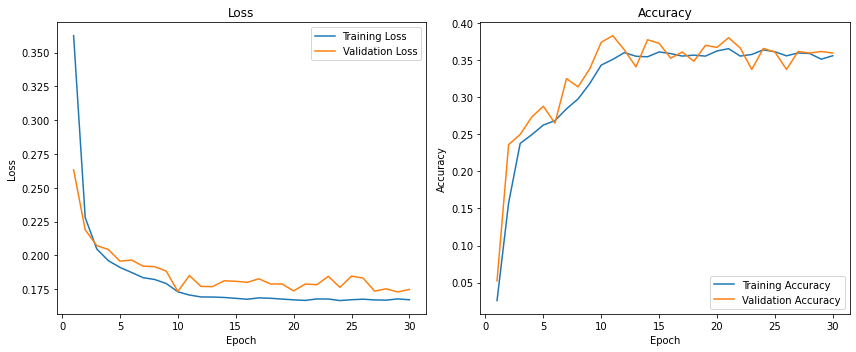

In [87]:
util.plot_classification(train_losses_m1, train_accuracies_m1, val_losses_m1, val_accuracies_m1)

In [89]:
# 2 original dropout layers 
# reduce weight decay to increase accuracy

m2 = MultiConvClassifier(NCLASSES)
m2 = util.bind_gpu(m2)
util.load_weights_from_dict(m2, 'Models/m1.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m2.parameters(), weight_decay = 0.005)

train_losses_m2, train_accuracies_m2, val_losses_m2, val_accuracies_m2 = train_classification_with_validation(m2, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3865, Train Accuracy: 0.0595
Epoch [1/15], Validation Loss: 0.2416, Validation Accuracy: 0.0834
Epoch [2/15], Train Loss: 0.1993, Train Accuracy: 0.2183
Epoch [2/15], Validation Loss: 0.1847, Validation Accuracy: 0.3131
Epoch [3/15], Train Loss: 0.1620, Train Accuracy: 0.3784
Epoch [3/15], Validation Loss: 0.1645, Validation Accuracy: 0.4055
Epoch [4/15], Train Loss: 0.1486, Train Accuracy: 0.4584
Epoch [4/15], Validation Loss: 0.1612, Validation Accuracy: 0.4556
Epoch [5/15], Train Loss: 0.1451, Train Accuracy: 0.4827
Epoch [5/15], Validation Loss: 0.1529, Validation Accuracy: 0.4634
Epoch [6/15], Train Loss: 0.1418, Train Accuracy: 0.4905
Epoch [6/15], Validation Loss: 0.1572, Validation Accuracy: 0.4600
Epoch [7/15], Train Loss: 0.1390, Train Accuracy: 0.5018
Epoch [7/15], Validation Loss: 0.1535, Validation Accuracy: 0.4848
Epoch [8/15], Train Loss: 0.1363, Train Accuracy: 0.5168
Epoch [8/15], Validation Loss: 0.1605, Validation Accuracy: 0.4972
Epoch [9

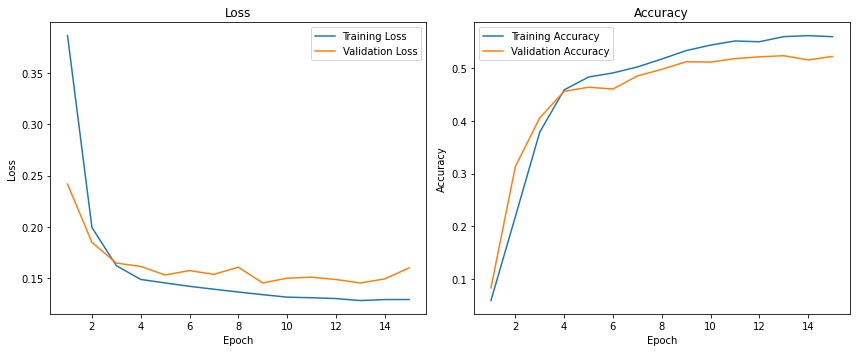

In [90]:
util.plot_classification(train_losses_m2, train_accuracies_m2, val_losses_m2, val_accuracies_m2)

In [97]:
# save model
torch.save(m2, 'Models/mm2_full.pth')
torch.save(m2.state_dict(), 'Models/mm2.pth')

In [91]:
# 2 original dropout layers 
# reduce weight decay to increase accuracy

m3 = MultiConvClassifier(NCLASSES)
m3 = util.bind_gpu(m3)
util.load_weights_from_dict(m3, 'Models/m1.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m3.parameters(), weight_decay = 0.0075)

train_losses_m3, train_accuracies_m3, val_losses_m3, val_accuracies_m3 = train_classification_with_validation(m3, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3500, Train Accuracy: 0.0253
Epoch [1/15], Validation Loss: 0.2490, Validation Accuracy: 0.0697
Epoch [2/15], Train Loss: 0.2180, Train Accuracy: 0.1580
Epoch [2/15], Validation Loss: 0.2067, Validation Accuracy: 0.2324
Epoch [3/15], Train Loss: 0.1942, Train Accuracy: 0.2538
Epoch [3/15], Validation Loss: 0.1937, Validation Accuracy: 0.3000
Epoch [4/15], Train Loss: 0.1797, Train Accuracy: 0.3114
Epoch [4/15], Validation Loss: 0.1798, Validation Accuracy: 0.3414
Epoch [5/15], Train Loss: 0.1670, Train Accuracy: 0.3620
Epoch [5/15], Validation Loss: 0.1766, Validation Accuracy: 0.3669
Epoch [6/15], Train Loss: 0.1597, Train Accuracy: 0.3970
Epoch [6/15], Validation Loss: 0.1699, Validation Accuracy: 0.3966
Epoch [7/15], Train Loss: 0.1575, Train Accuracy: 0.4063
Epoch [7/15], Validation Loss: 0.1686, Validation Accuracy: 0.4090
Epoch [8/15], Train Loss: 0.1559, Train Accuracy: 0.4189
Epoch [8/15], Validation Loss: 0.1683, Validation Accuracy: 0.4152
Epoch [9

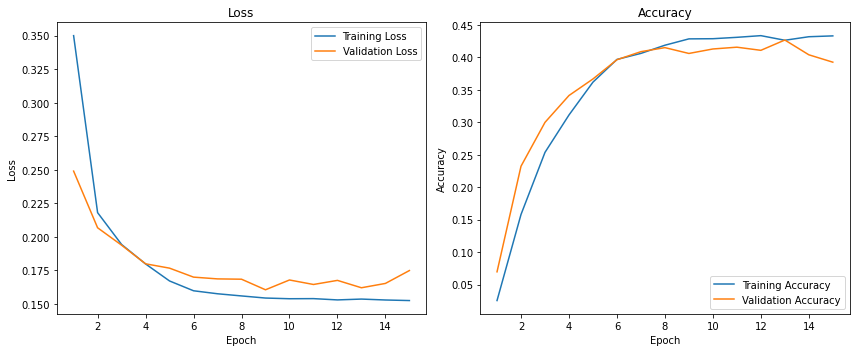

In [92]:
util.plot_classification(train_losses_m3, train_accuracies_m3, val_losses_m3, val_accuracies_m3)

### M4 single classifier base with hyperparameter tuning

In [93]:
# 2 original dropout layers 
# weight decay also original

m4= MultiConvClassifier(NCLASSES)
m4 = util.bind_gpu(m4)
util.load_weights_from_dict(m4, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m4.parameters(), weight_decay = 0.01)

train_losses_m4, train_accuracies_m4, val_losses_m4, val_accuracies_m4 = train_classification_with_validation(m4, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.4026, Train Accuracy: 0.0298
Epoch [1/15], Validation Loss: 0.3005, Validation Accuracy: 0.0000
Epoch [2/15], Train Loss: 0.2751, Train Accuracy: 0.0319
Epoch [2/15], Validation Loss: 0.2547, Validation Accuracy: 0.0731
Epoch [3/15], Train Loss: 0.2423, Train Accuracy: 0.0709
Epoch [3/15], Validation Loss: 0.2470, Validation Accuracy: 0.0938
Epoch [4/15], Train Loss: 0.2345, Train Accuracy: 0.0796
Epoch [4/15], Validation Loss: 0.2370, Validation Accuracy: 0.0779
Epoch [5/15], Train Loss: 0.2296, Train Accuracy: 0.0985
Epoch [5/15], Validation Loss: 0.2336, Validation Accuracy: 0.1014
Epoch [6/15], Train Loss: 0.2248, Train Accuracy: 0.1315
Epoch [6/15], Validation Loss: 0.2298, Validation Accuracy: 0.0959
Epoch [7/15], Train Loss: 0.2219, Train Accuracy: 0.1484
Epoch [7/15], Validation Loss: 0.2263, Validation Accuracy: 0.1752
Epoch [8/15], Train Loss: 0.2211, Train Accuracy: 0.1550
Epoch [8/15], Validation Loss: 0.2253, Validation Accuracy: 0.1434
Epoch [9

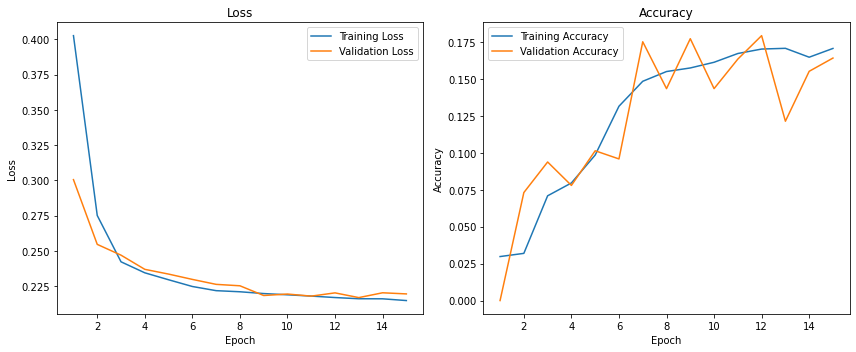

In [94]:
util.plot_classification(train_losses_m4, train_accuracies_m4, val_losses_m4, val_accuracies_m4)

In [95]:
# 2 original dropout layers 
# weight decay reduced 10 times

m5= MultiConvClassifier(NCLASSES)
m5 = util.bind_gpu(m5)
util.load_weights_from_dict(m5, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m5.parameters(), weight_decay = 0.001)

train_losses_m5, train_accuracies_m5, val_losses_m5, val_accuracies_m5 = train_classification_with_validation(m5, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3564, Train Accuracy: 0.0213
Epoch [1/15], Validation Loss: 0.2533, Validation Accuracy: 0.0421
Epoch [2/15], Train Loss: 0.2241, Train Accuracy: 0.1287
Epoch [2/15], Validation Loss: 0.2098, Validation Accuracy: 0.2131
Epoch [3/15], Train Loss: 0.1896, Train Accuracy: 0.2797
Epoch [3/15], Validation Loss: 0.1795, Validation Accuracy: 0.3386
Epoch [4/15], Train Loss: 0.1703, Train Accuracy: 0.3704
Epoch [4/15], Validation Loss: 0.1751, Validation Accuracy: 0.3703
Epoch [5/15], Train Loss: 0.1634, Train Accuracy: 0.4017
Epoch [5/15], Validation Loss: 0.1647, Validation Accuracy: 0.4269
Epoch [6/15], Train Loss: 0.1588, Train Accuracy: 0.4337
Epoch [6/15], Validation Loss: 0.1620, Validation Accuracy: 0.4607
Epoch [7/15], Train Loss: 0.1567, Train Accuracy: 0.4478
Epoch [7/15], Validation Loss: 0.1595, Validation Accuracy: 0.4655
Epoch [8/15], Train Loss: 0.1542, Train Accuracy: 0.4599
Epoch [8/15], Validation Loss: 0.1630, Validation Accuracy: 0.4652
Epoch [9

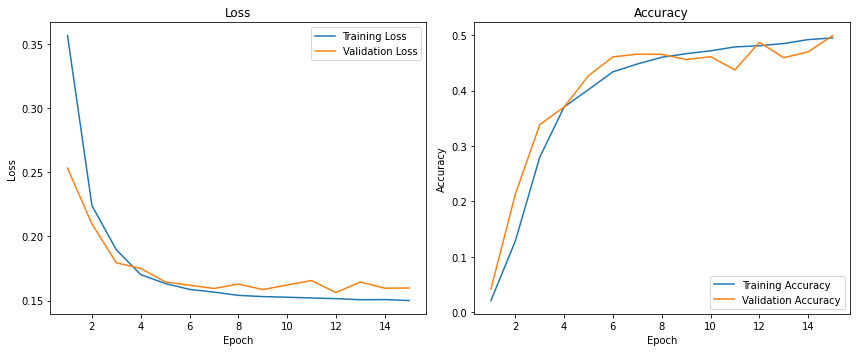

In [96]:
util.plot_classification(train_losses_m5, train_accuracies_m5, val_losses_m5, val_accuracies_m5)

In [98]:
# save model
torch.save(m5, 'Models/mm5_full.pth')
torch.save(m5.state_dict(), 'Models/mm5.pth')

In [99]:
# 2 original dropout layers 
# further reduced

m6= MultiConvClassifier(NCLASSES)
m6 = util.bind_gpu(m6)
util.load_weights_from_dict(m6, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m6.parameters(), weight_decay = 0.0005)

train_losses_m6, train_accuracies_m6, val_losses_m6, val_accuracies_m6 = train_classification_with_validation(m6, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3658, Train Accuracy: 0.0282
Epoch [1/15], Validation Loss: 0.2414, Validation Accuracy: 0.0359
Epoch [2/15], Train Loss: 0.2034, Train Accuracy: 0.2107
Epoch [2/15], Validation Loss: 0.1772, Validation Accuracy: 0.3386
Epoch [3/15], Train Loss: 0.1652, Train Accuracy: 0.4111
Epoch [3/15], Validation Loss: 0.1635, Validation Accuracy: 0.4248
Epoch [4/15], Train Loss: 0.1580, Train Accuracy: 0.4527
Epoch [4/15], Validation Loss: 0.1666, Validation Accuracy: 0.4272
Epoch [5/15], Train Loss: 0.1557, Train Accuracy: 0.4703
Epoch [5/15], Validation Loss: 0.1582, Validation Accuracy: 0.4569
Epoch [6/15], Train Loss: 0.1537, Train Accuracy: 0.4768
Epoch [6/15], Validation Loss: 0.1574, Validation Accuracy: 0.4893
Epoch [7/15], Train Loss: 0.1526, Train Accuracy: 0.4834
Epoch [7/15], Validation Loss: 0.1578, Validation Accuracy: 0.4790
Epoch [8/15], Train Loss: 0.1519, Train Accuracy: 0.4872
Epoch [8/15], Validation Loss: 0.1618, Validation Accuracy: 0.4762
Epoch [9

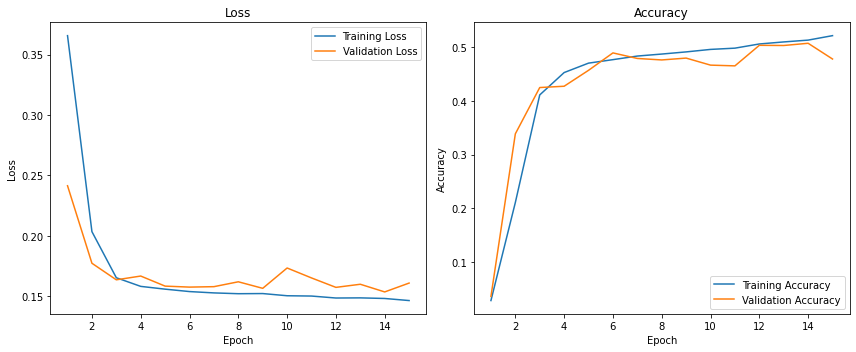

In [100]:
util.plot_classification(train_losses_m6, train_accuracies_m6, val_losses_m6, val_accuracies_m6)

In [105]:
# save model
torch.save(m6, 'Models/mm6_full.pth')
torch.save(m6.state_dict(), 'Models/mm6.pth')

In [101]:
# 2 original dropout layers 

m7= MultiConvClassifier(NCLASSES)
m7 = util.bind_gpu(m7)
util.load_weights_from_dict(m7, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m7.parameters())

train_losses_m7, train_accuracies_m7, val_losses_m7, val_accuracies_m7 = train_classification_with_validation(m7, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3728, Train Accuracy: 0.0166
Epoch [1/15], Validation Loss: 0.2450, Validation Accuracy: 0.0303
Epoch [2/15], Train Loss: 0.2039, Train Accuracy: 0.1942
Epoch [2/15], Validation Loss: 0.1868, Validation Accuracy: 0.2979
Epoch [3/15], Train Loss: 0.1785, Train Accuracy: 0.3388
Epoch [3/15], Validation Loss: 0.1731, Validation Accuracy: 0.3693
Epoch [4/15], Train Loss: 0.1687, Train Accuracy: 0.3861
Epoch [4/15], Validation Loss: 0.1725, Validation Accuracy: 0.4041
Epoch [5/15], Train Loss: 0.1626, Train Accuracy: 0.4251
Epoch [5/15], Validation Loss: 0.1629, Validation Accuracy: 0.4445
Epoch [6/15], Train Loss: 0.1575, Train Accuracy: 0.4620
Epoch [6/15], Validation Loss: 0.1615, Validation Accuracy: 0.4624
Epoch [7/15], Train Loss: 0.1547, Train Accuracy: 0.4797
Epoch [7/15], Validation Loss: 0.1604, Validation Accuracy: 0.4672
Epoch [8/15], Train Loss: 0.1532, Train Accuracy: 0.4926
Epoch [8/15], Validation Loss: 0.1616, Validation Accuracy: 0.4672
Epoch [9

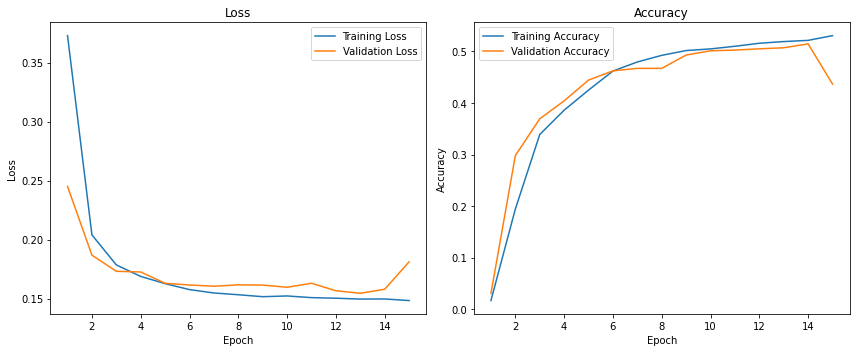

In [102]:
util.plot_classification(train_losses_m7, train_accuracies_m7, val_losses_m7, val_accuracies_m7)

In [106]:
# save model
torch.save(m7, 'Models/mm7_full.pth')
torch.save(m7.state_dict(), 'Models/mm7.pth')

In [103]:
# 2 original dropout layers 
# further reduced

m8= MultiConvClassifier(NCLASSES)
m8 = util.bind_gpu(m8)
util.load_weights_from_dict(m8, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m8.parameters(), weight_decay = 0.0001)

train_losses_m8, train_accuracies_m8, val_losses_m8, val_accuracies_m8 = train_classification_with_validation(m8, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3771, Train Accuracy: 0.0203
Epoch [1/15], Validation Loss: 0.2461, Validation Accuracy: 0.0759
Epoch [2/15], Train Loss: 0.2035, Train Accuracy: 0.2029
Epoch [2/15], Validation Loss: 0.1863, Validation Accuracy: 0.2841
Epoch [3/15], Train Loss: 0.1686, Train Accuracy: 0.3729
Epoch [3/15], Validation Loss: 0.1642, Validation Accuracy: 0.4203
Epoch [4/15], Train Loss: 0.1574, Train Accuracy: 0.4495
Epoch [4/15], Validation Loss: 0.1650, Validation Accuracy: 0.4369
Epoch [5/15], Train Loss: 0.1530, Train Accuracy: 0.4759
Epoch [5/15], Validation Loss: 0.1650, Validation Accuracy: 0.4766
Epoch [6/15], Train Loss: 0.1511, Train Accuracy: 0.4948
Epoch [6/15], Validation Loss: 0.1578, Validation Accuracy: 0.4797
Epoch [7/15], Train Loss: 0.1484, Train Accuracy: 0.5087
Epoch [7/15], Validation Loss: 0.1562, Validation Accuracy: 0.5114
Epoch [8/15], Train Loss: 0.1476, Train Accuracy: 0.5227
Epoch [8/15], Validation Loss: 0.1525, Validation Accuracy: 0.5031
Epoch [9

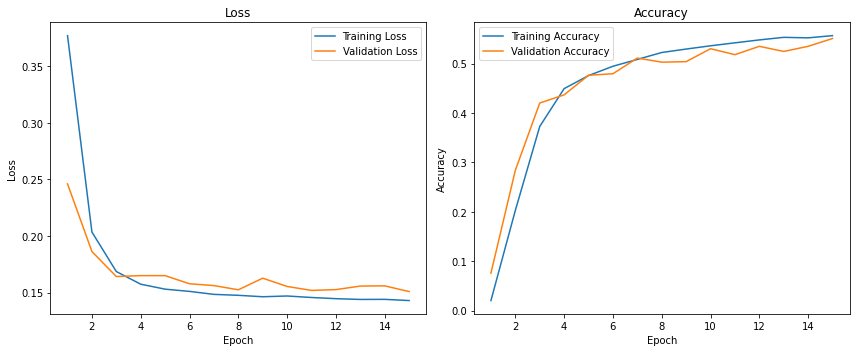

In [104]:
util.plot_classification(train_losses_m8, train_accuracies_m8, val_losses_m8, val_accuracies_m8)

In [107]:
# save model
torch.save(m8, 'Models/mm8_full.pth')
torch.save(m8.state_dict(), 'Models/mm8.pth')

In [108]:
# 2 original dropout layers 
# further reduced

m9= MultiConvClassifier(NCLASSES)
m9 = util.bind_gpu(m9)
util.load_weights_from_dict(m9, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m9.parameters(), weight_decay = 0.00001)

train_losses_m9, train_accuracies_m9, val_losses_m9, val_accuracies_m9 = train_classification_with_validation(m9, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3630, Train Accuracy: 0.0162
Epoch [1/15], Validation Loss: 0.2480, Validation Accuracy: 0.0097
Epoch [2/15], Train Loss: 0.2150, Train Accuracy: 0.1762
Epoch [2/15], Validation Loss: 0.1909, Validation Accuracy: 0.2772
Epoch [3/15], Train Loss: 0.1818, Train Accuracy: 0.3157
Epoch [3/15], Validation Loss: 0.1778, Validation Accuracy: 0.3359
Epoch [4/15], Train Loss: 0.1701, Train Accuracy: 0.3778
Epoch [4/15], Validation Loss: 0.1691, Validation Accuracy: 0.4045
Epoch [5/15], Train Loss: 0.1635, Train Accuracy: 0.4352
Epoch [5/15], Validation Loss: 0.1725, Validation Accuracy: 0.4214
Epoch [6/15], Train Loss: 0.1585, Train Accuracy: 0.4550
Epoch [6/15], Validation Loss: 0.1619, Validation Accuracy: 0.4524
Epoch [7/15], Train Loss: 0.1559, Train Accuracy: 0.4699
Epoch [7/15], Validation Loss: 0.1650, Validation Accuracy: 0.4541
Epoch [8/15], Train Loss: 0.1532, Train Accuracy: 0.4775
Epoch [8/15], Validation Loss: 0.1738, Validation Accuracy: 0.4769
Epoch [9

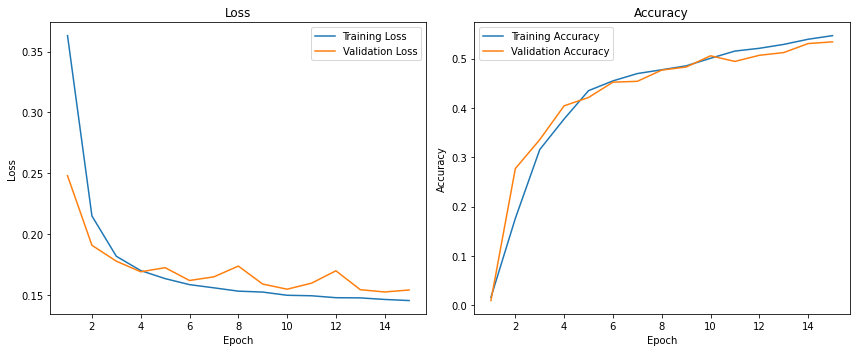

In [109]:
util.plot_classification(train_losses_m9, train_accuracies_m9, val_losses_m9, val_accuracies_m9)

In [110]:
# save model
torch.save(m9, 'Models/mm9_full.pth')
torch.save(m9.state_dict(), 'Models/mm9.pth')

In [111]:
# 2 original dropout layers 
# further reduced

m10= MultiConvClassifier(NCLASSES)
m10 = util.bind_gpu(m10)
util.load_weights_from_dict(m10, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m10.parameters(), weight_decay = 0.000001)

train_losses_m10, train_accuracies_m10, val_losses_m10, val_accuracies_m10 = train_classification_with_validation(m10, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3942, Train Accuracy: 0.0207
Epoch [1/15], Validation Loss: 0.2659, Validation Accuracy: 0.0000
Epoch [2/15], Train Loss: 0.2248, Train Accuracy: 0.1346
Epoch [2/15], Validation Loss: 0.1983, Validation Accuracy: 0.2628
Epoch [3/15], Train Loss: 0.1803, Train Accuracy: 0.3242
Epoch [3/15], Validation Loss: 0.1754, Validation Accuracy: 0.4048
Epoch [4/15], Train Loss: 0.1661, Train Accuracy: 0.4141
Epoch [4/15], Validation Loss: 0.1698, Validation Accuracy: 0.4548
Epoch [5/15], Train Loss: 0.1597, Train Accuracy: 0.4546
Epoch [5/15], Validation Loss: 0.1654, Validation Accuracy: 0.4748
Epoch [6/15], Train Loss: 0.1551, Train Accuracy: 0.4720
Epoch [6/15], Validation Loss: 0.1669, Validation Accuracy: 0.4793
Epoch [7/15], Train Loss: 0.1528, Train Accuracy: 0.4885
Epoch [7/15], Validation Loss: 0.1643, Validation Accuracy: 0.4800
Epoch [8/15], Train Loss: 0.1513, Train Accuracy: 0.5029
Epoch [8/15], Validation Loss: 0.1592, Validation Accuracy: 0.4907
Epoch [9

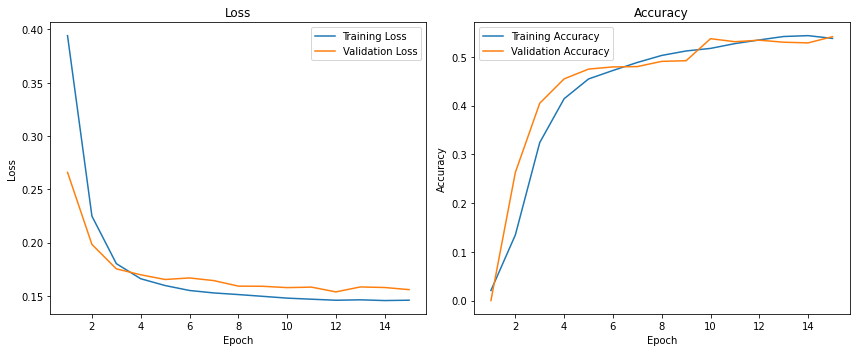

In [114]:
util.plot_classification(train_losses_m10, train_accuracies_m10, val_losses_m10, val_accuracies_m10)

In [115]:
# 2 original dropout layers 
# further reduced

m11= MultiConvClassifier(NCLASSES)
m11 = util.bind_gpu(m11)
util.load_weights_from_dict(m11, 'Models/m4.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m11.parameters(), weight_decay = 0.000005)

train_losses_m11, train_accuracies_m11, val_losses_m11, val_accuracies_m11 = train_classification_with_validation(m11, criterion, optimizer, N_EPOCHS//2, dl_train, dl_val)

<ipython-input-8-2e9077dfe2ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


Epoch [1/15], Train Loss: 0.3889, Train Accuracy: 0.0223
Epoch [1/15], Validation Loss: 0.2737, Validation Accuracy: 0.0014
Epoch [2/15], Train Loss: 0.2281, Train Accuracy: 0.1263
Epoch [2/15], Validation Loss: 0.1977, Validation Accuracy: 0.2662
Epoch [3/15], Train Loss: 0.1806, Train Accuracy: 0.3373
Epoch [3/15], Validation Loss: 0.1738, Validation Accuracy: 0.4100
Epoch [4/15], Train Loss: 0.1643, Train Accuracy: 0.4210
Epoch [4/15], Validation Loss: 0.1671, Validation Accuracy: 0.4431
Epoch [5/15], Train Loss: 0.1595, Train Accuracy: 0.4548
Epoch [5/15], Validation Loss: 0.1671, Validation Accuracy: 0.4507
Epoch [6/15], Train Loss: 0.1566, Train Accuracy: 0.4704
Epoch [6/15], Validation Loss: 0.1680, Validation Accuracy: 0.4807
Epoch [7/15], Train Loss: 0.1558, Train Accuracy: 0.4872
Epoch [7/15], Validation Loss: 0.1776, Validation Accuracy: 0.4555
Epoch [8/15], Train Loss: 0.1552, Train Accuracy: 0.4864
Epoch [8/15], Validation Loss: 0.1653, Validation Accuracy: 0.4697
Epoch [9

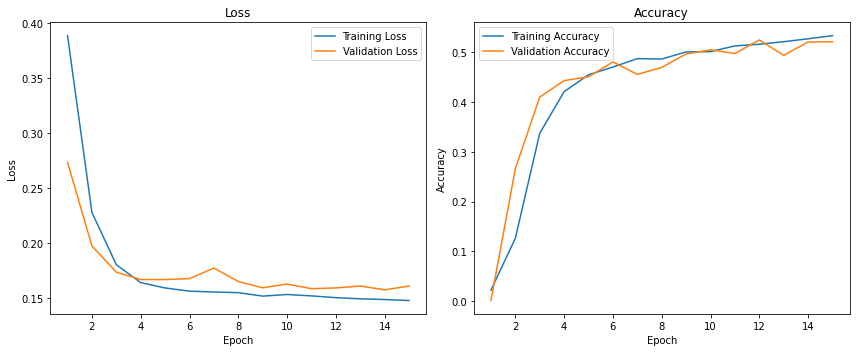

In [127]:
util.plot_classification(train_losses_m11, train_accuracies_m11, val_losses_m11, val_accuracies_m11)

### Testing Final Model - m8

Based on the above training with validation results, m8 appears to have the best accuracy to overfitting performance. Therefore, we select m8 (base is m4 single label model) as our final model.

In [3]:
# test model
def test_classification(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_F1= 0.0
    device = util.get_device()

    with torch.no_grad():  # No gradient computation during test
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs.squeeze(), labels).item()
        
            predicted = (torch.sigmoid(outputs) > 0.5) * 1 # 1 or 0
            
            tensor_sum = predicted + labels
            
            # calculate TP, FP, FN, union
            
            union = torch.sum(tensor_sum > 0, 1)
            
            intersection = torch.sum(tensor_sum > 1 , 1) # also TP
            
            FP = torch.sum(((predicted > 1)*1 + (labels <1)*1) > 1, 1)
            
            FN = torch.sum(((predicted < 1)*1 + (labels >1)*1) > 1, 1)
        
            
            precision =  torch.sum(torch.nan_to_num(intersection/(intersection+FP)))
    
            recall = torch.sum(torch.nan_to_num(intersection/(intersection+FN)))
          
            total_correct += torch.sum(intersection / union)
            
            total_precision += precision
            
            total_recall += recall
            
            if precision + recall !=0:
                
                total_F1 += (2*precision*recall)/(precision+recall)
            
            

    # compute metrics
    
    accuracy = total_correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    precision = total_precision / len(loader.dataset)
    recall = total_recall / len(loader.dataset)
    F1 = total_F1 / len(loader.dataset)
    
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average loss: {avg_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1:.4f}")

In [6]:
model= MultiConvClassifier(NCLASSES)
util.load_weights_from_dict(model, 'Models/mm8.pth')
criterion = nn.BCEWithLogitsLoss()

# Read DataLoaders from pickle files
dl_test = pickle.load(open('Data/dataLoaderTest.pkl', 'rb'))

In [7]:
test_classification(model, criterion, dl_test)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x00000206428AA940>
Accuracy: 0.3500
Average loss: 0.5071
Precision: 0.5214
Recall: 0.5214
F1 Score: 0.5214
